In [4]:
%cd ~/SSMuLA
%load_ext autoreload
%autoreload 2

/disk2/fli/SSMuLA
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd

from scipy.stats import spearmanr, ttest_ind

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from SSMuLA.zs_analysis import (
    ZS_OPTS,
    ZS_OPTS_LEGEND,
    SIX_ZS_COLORS,
    ZS_METRIC_MAP_TITLE,
    plot_app_type_zs,
)
from SSMuLA.vis import save_svg

%matplotlib inline

In [6]:
zs_df = pd.read_csv("results4upload/zs_sum/zs_stat_parsed.csv")
zs_df

,lib,all_ed_rho,all_ed_ndcg,all_ed_rocauc,all_ev_rho,all_ev_ndcg,all_ev_rocauc,all_esm_rho,all_esm_ndcg,all_esm_rocauc,...,single_ev-esm-esmif_ndcg,single_ev-esm-esmif_rocauc,single_Triad-ev-esm-esmif_rho,single_Triad-ev-esm-esmif_ndcg,single_Triad-ev-esm-esmif_rocauc,single_two-best_rho,single_two-best_ndcg,single_two-best_rocauc,type,msa
0,DHFR,0.251154,0.914803,0.719973,0.339650,0.947058,0.912765,0.299715,0.934129,0.848592,...,0.891577,0.911111,-0.212895,0.800908,0.320833,0.555344,0.897379,0.900000,Enzyme activity,16042
1,GB1,0.144928,0.687396,0.577572,0.189509,0.721558,0.627690,0.080335,0.701680,0.558014,...,0.784778,0.897363,0.811746,0.786033,0.916196,0.779265,0.788547,0.898305,Binding,29
2,ParD2,0.297552,0.943588,0.552103,0.439506,0.950963,0.664011,0.508609,0.968482,0.701737,...,0.977412,0.947368,0.687594,0.988506,0.964912,0.674367,0.976621,0.947368,Binding,6789
3,ParD3,0.456371,0.969538,0.564976,0.460817,0.971281,0.705520,0.583158,0.982041,0.755986,...,0.995510,NaN,0.337783,0.993260,NaN,0.362577,0.995431,NaN,Binding,6784
4,T7,0.123445,0.611561,0.625880,0.073662,0.619888,0.626332,0.068403,0.595811,0.607808,...,0.818903,0.662222,0.278265,0.743581,0.771111,0.247554,0.826064,0.666667,Enzyme activity,309
5,TEV,0.119715,0.992653,0.558518,0.125519,0.993482,0.584816,0.117589,0.993142,0.570008,...,0.964957,0.886570,0.732557,0.962853,0.868421,0.734003,0.967017,0.886570,Enzyme activity,164
6,TrpB3A,0.177658,0.987543,0.608694,0.130969,0.989105,0.657328,0.199229,0.988920,0.690492,...,0.967964,0.850694,0.191181,0.877321,0.646991,0.441304,0.967677,0.863426,Enzyme activity,5816
7,TrpB3B,0.021137,0.987234,0.551217,0.074495,0.988502,0.583225,0.053335,0.988071,0.659787,...,0.972462,0.981481,0.176627,0.941640,0.796296,0.367140,0.975559,0.972222,Enzyme activity,5816
8,TrpB3C,0.064914,0.983205,0.605496,0.111510,0.984379,0.539872,0.065783,0.984411,0.580109,...,0.959543,1.000000,0.277220,0.954619,0.996970,0.386139,0.950518,0.993939,Enzyme activity,5816
9,TrpB3D,0.113428,0.972850,0.609910,0.229525,0.980522,0.785684,0.221182,0.979785,0.745673,...,0.867780,0.682382,0.378123,0.831905,0.699132,0.377664,0.851802,0.678040,Enzyme activity,5816


In [7]:
lib_stat = pd.read_csv("results4upload/landscape/lib_stats.csv")
active_cutoff = 1
active_lib_list = lib_stat[(lib_stat["percent_active"]>=active_cutoff)]["lib"].tolist() # & (lib_stat["percent_measured"]>=90)
active_lib_list

['DHFR',
 'ParD2',
 'ParD3',
 'GB1',
 'T7',
 'TEV',
 'TrpB3D',
 'TrpB3E',
 'TrpB3F',
 'TrpB3G',
 'TrpB3I',
 'TrpB4']

In [8]:
slice_zs = zs_df[zs_df["lib"].isin(active_lib_list)].copy()

In [9]:
avg_bar_type_df_list = []

for m in ["rho", "rocauc"]:
    for x in ZS_OPTS:
        x = "all_" + x.split("_")[0] + "_" + m
        bar_type_df = slice_zs[["lib", "type", x]].copy()
        bar_type_df = (
            bar_type_df[["type", x]].groupby("type").agg(["mean", "std"]).reset_index()
        )

        bar_type_df.columns = ["{}_{}".format(i, j) for i, j in bar_type_df.columns]

        bar_m_df = bar_type_df.melt(id_vars="type_", var_name="zs", value_name="value")

        bar_m_df["metric"] = m
        avg_bar_type_df_list.append(bar_m_df)
        avg_bar_type_df_list.append(
            pd.DataFrame(
                {
                    "type_": "Both",
                    "zs": x + "_mean",
                    "value": bar_type_df[x + "_mean"].mean(),
                    "metric": m,
                },
                index=[0],
            )
        )
        avg_bar_type_df_list.append(
            pd.DataFrame(
                {
                    "type_": "Both",
                    "zs": x + "_std",
                    "value": bar_type_df[x + "_std"].mean(),
                    "metric": m,
                },
                index=[0],
            )
        )

avg_bar_type_df = pd.concat(avg_bar_type_df_list, axis=0)
avg_bar_type_df["calc"] = avg_bar_type_df["zs"].apply(lambda x: x.split("_")[-1])
avg_bar_type_df["zs"] = (
    avg_bar_type_df["zs"]
    .apply(lambda x: x.split("_")[1] + "_score")
    .map(ZS_OPTS_LEGEND)
)

avg_bar_type_df["metric"] = avg_bar_type_df["metric"].map(ZS_METRIC_MAP_TITLE)
avg_bar_type_df = avg_bar_type_df.replace({"Binding": "Binding interaction"})
avg_bar_type_df

,type_,zs,value,metric,calc
0,Binding interaction,Hamming distance,0.299617,Fitness ranking\n(Spearman's ρ),mean
1,Enzyme activity,Hamming distance,0.138574,Fitness ranking\n(Spearman's ρ),mean
2,Binding interaction,Hamming distance,0.155732,Fitness ranking\n(Spearman's ρ),std
3,Enzyme activity,Hamming distance,0.066167,Fitness ranking\n(Spearman's ρ),std
0,Both,Hamming distance,0.219095,Fitness ranking\n(Spearman's ρ),mean
...,...,...,...,...,...
1,Enzyme activity,Triad,0.657257,Active / inactive classification\n(ROC-AUC),mean
2,Binding interaction,Triad,0.132288,Active / inactive classification\n(ROC-AUC),std
3,Enzyme activity,Triad,0.151042,Active / inactive classification\n(ROC-AUC),std
0,Both,Triad,0.707618,Active / inactive classification\n(ROC-AUC),mean


In [10]:
df_msa = pd.DataFrame()

for zs in ZS_OPTS:
    for m in ["rho", "rocauc"]:
        zs_col = "all_" + zs.replace("score", m)
        zs_rho_both, zs_p_both= spearmanr(slice_zs[zs_col], slice_zs["msa"])
        df_msa = df_msa._append({"type": "Both", "zs": zs, "metric": m, "value": zs_rho_both, "p": zs_p_both}, ignore_index=True)

df_msa["zs"] = df_msa["zs"].map(ZS_OPTS_LEGEND)
df_msa["metric"] = df_msa["metric"].map(ZS_METRIC_MAP_TITLE)
df_msa = df_msa.replace({"Binding": "Binding interaction"})

df_msa

,type,zs,metric,value,p
0,Both,Hamming distance,Fitness ranking\n(Spearman's ρ),0.541188,0.069203
1,Both,Hamming distance,Active / inactive classification\n(ROC-AUC),0.026126,0.935763
2,Both,EVmutation,Fitness ranking\n(Spearman's ρ),0.485203,0.109835
3,Both,EVmutation,Active / inactive classification\n(ROC-AUC),0.507597,0.092058
4,Both,ESM,Fitness ranking\n(Spearman's ρ),0.709143,0.009810
5,Both,ESM,Active / inactive classification\n(ROC-AUC),0.526259,0.078814
6,Both,ESM-IF,Fitness ranking\n(Spearman's ρ),0.544920,0.066933
7,Both,ESM-IF,Active / inactive classification\n(ROC-AUC),0.608370,0.035814
8,Both,CoVES,Fitness ranking\n(Spearman's ρ),0.029859,0.926607
9,Both,CoVES,Active / inactive classification\n(ROC-AUC),0.145561,0.651713


Fitness ranking
(Spearman's ρ) ed_score: rho=0.541, p=0.069
Fitness ranking
(Spearman's ρ) ev_score: rho=0.485, p=0.110
Fitness ranking
(Spearman's ρ) esm_score: rho=0.709, p=0.010
is significant!
Fitness ranking
(Spearman's ρ) esmif_score: rho=0.545, p=0.067
Fitness ranking
(Spearman's ρ) coves_score: rho=0.030, p=0.927
Fitness ranking
(Spearman's ρ) Triad_score: rho=-0.052, p=0.872


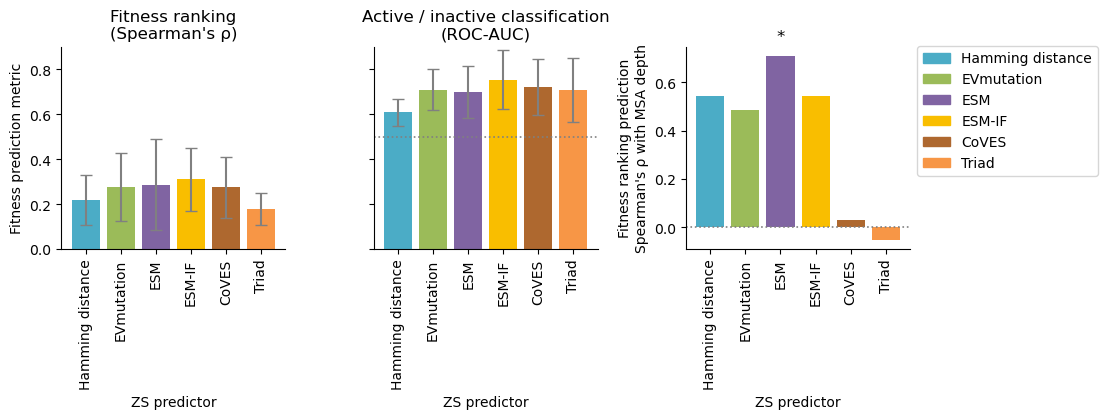

In [11]:
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(9, 4))  # Adjusted to 1x3 grid

# First two plots (from the first part of your code)
for m, ax in zip(
    avg_bar_type_df["metric"].unique(), axes[:2]
):  # Use the first two axes

    slice_m = avg_bar_type_df[
        (avg_bar_type_df["metric"] == m) & (avg_bar_type_df["type_"] == "Both")
    ].copy()

    # Perform t-tests between each pair of ZS predictors within the metric
    p_values = {}
    for zs1 in ZS_OPTS:
        for zs2 in ZS_OPTS:
            if zs1 < zs2:  # To ensure each pair is only tested once
                group1 = slice_m[slice_m["zs"] == zs1]["value"]
                group2 = slice_m[slice_m["zs"] == zs2]["value"]
                _, p_value = ttest_ind(group1, group2)
                p_values[f"{zs1} vs {zs2}"] = p_value

    means = slice_m[slice_m["calc"] == "mean"]["value"].tolist()

    bars = ax.bar(
        [ZS_OPTS_LEGEND[zs] for zs in ZS_OPTS],
        means,
        yerr=slice_m[slice_m["calc"] == "std"]["value"].tolist(),
        capsize=4,
        color=[SIX_ZS_COLORS[c] for c in ZS_OPTS],
        width=0.8,
        error_kw={"ecolor": "gray", "capthick": 1},
    )

    # Annotating p-values
    for i, (pair, p_value) in enumerate(p_values.items()):
        if p_value < 0.05:
            ax.text(i, max(means) + 10, "*", ha="center", color="gray")

    # Hide the top and right spines
    if "classification" in m:
        ax.axhline(0.5, color="gray", linestyle="dotted", lw=1.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)  # Disable the y-axis grid lines
    ax.set_ylim([0, 0.9])
    ax.tick_params(axis="x", rotation=90)
    ax.set_title(m)
    ax.set_xlabel("ZS predictor")

axes[0].set_ylabel("Fitness prediction metric")
# hide the y-axis label for the second plot
axes[1].set_ylabel("")
# remove y axis ticks label for the second plot
axes[1].set_yticklabels([])
# Third plot (from the second part of your code)
ax = axes[2]  # Use the third axis

# Filter for the specific metric and type (for the first subplot only)
m = df_msa["metric"].unique()[0]  # Only get the first metric
slice_m = df_msa[(df_msa["metric"] == m) & (df_msa["type"] == "Both")].copy()

# Plot vertical bars for the third subplot
bars = ax.bar(
    [ZS_OPTS_LEGEND[zs] for zs in ZS_OPTS],
    slice_m["value"],
    color=[SIX_ZS_COLORS[c] for c in ZS_OPTS],
    width=0.8,
)

# Annotate p-values on the bars
for j, bar in enumerate(bars):
    p_val = slice_m["p"].values[j]  # Assuming the p-values are in the "p" column
    rho_val = slice_m["value"].values[j]  # Corresponding rho value

    print(f"{m} {ZS_OPTS[j]}: rho={rho_val:.3f}, p={p_val:.3f}")

    if p_val < 0.05:
        print("is significant!")
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.05,
            "*",
            ha="center",
            va="bottom",
            color="black",
            fontsize=12,
        )

# Hide the top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)  # Disable the y-axis grid lines
ax.tick_params(axis="x", rotation=90)
ax.set_xlabel("ZS predictor")
ax.set_ylabel("Fitness ranking prediction\nSpearman's ρ with MSA depth")

# Add a horizontal line at 0
ax.axhline(0, color="gray", lw=1.2, ls="dotted")

# Create custom handles for the legend
handles = [
    mpatches.Patch(color=SIX_ZS_COLORS[zs], label=ZS_OPTS_LEGEND[zs]) for zs in ZS_OPTS
]

# Create a figure-wide legend
fig.legend(handles=handles, loc="upper left", bbox_to_anchor=(1, 0.925))
# Adjust spacing to move the second plot closer to the first
# plt.subplots_adjust(wspace=100)  # Decrease wspace to bring subplots closer

plt.tight_layout(pad=0.0, h_pad=-0.0, w_pad=1.5)
save_svg(fig, "3bc", "figs")

ed_score t=1.740 and p=0.210
ev_score t=1.738 and p=0.167
esm_score t=1.297 and p=0.308
esmif_score t=3.316 and p=0.052
coves_score t=3.641 and p=0.057
Triad_score t=4.332 and p=0.001


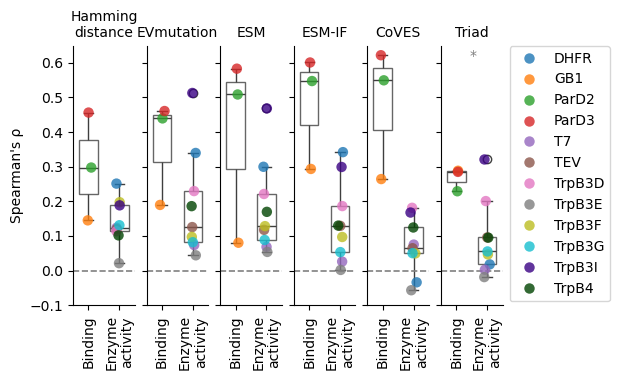

In [12]:
plot_app_type_zs(
    metric="rho",
    n_mut="all",
    slice_zs=slice_zs,
    fig_name = "4a",
    y_min = - 0.1,
    y_max = 0.65,
    y_annotation = 0.6
    # save_dir = "fig",
    # if_save = True,
)

ed_score t=-2.379 and p=0.042
ev_score t=-1.669 and p=0.126
esm_score t=-0.747 and p=0.493
esmif_score t=0.749 and p=0.494
coves_score t=1.289 and p=0.279
Triad_score t=1.101 and p=0.334


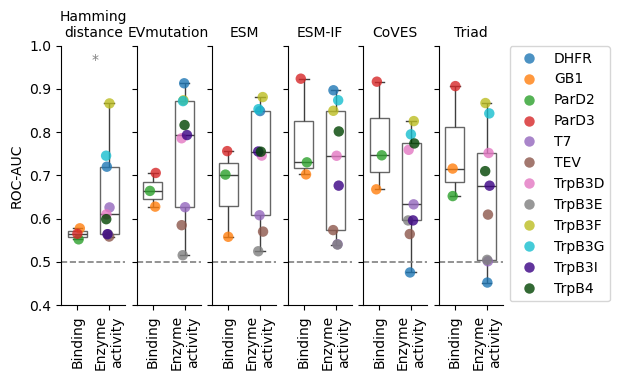

In [13]:
plot_app_type_zs(
    metric="rocauc",
    n_mut="all",
    slice_zs=slice_zs,
    fig_name = "4a",
    y_min = 0.4,
    y_max = 1,
    y_annotation = 0.95
    # save_dir = "fig",
    # if_save = True,
)

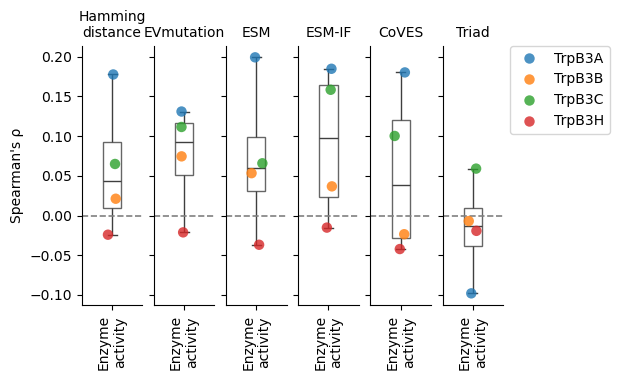

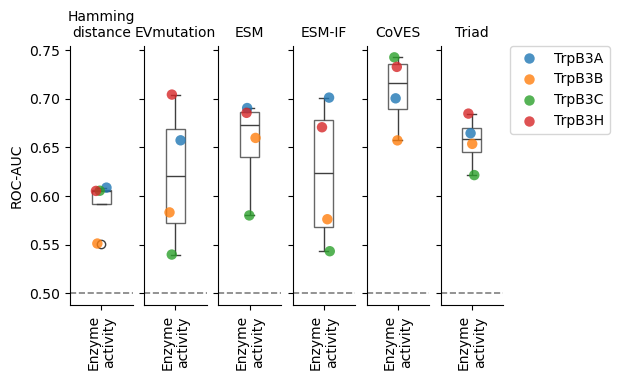

In [14]:
# for inactive
for m in ["rho", "rocauc"]:
    plot_app_type_zs(
        metric=m,
        n_mut="all",
        slice_zs=zs_df[
            zs_df["lib"].isin(
                lib_stat[~(lib_stat["percent_active"] >= active_cutoff)]["lib"].tolist()
            )
        ].copy(),
        # save_dir = "fig",
        fig_name="s13",
        # if_save = False,
    )

ed_score t=0.342 and p=0.742
ev_score t=-0.781 and p=0.488
esm_score t=0.475 and p=0.655
esmif_score t=1.075 and p=0.366
coves_score t=1.044 and p=0.367
Triad_score t=1.525 and p=0.207


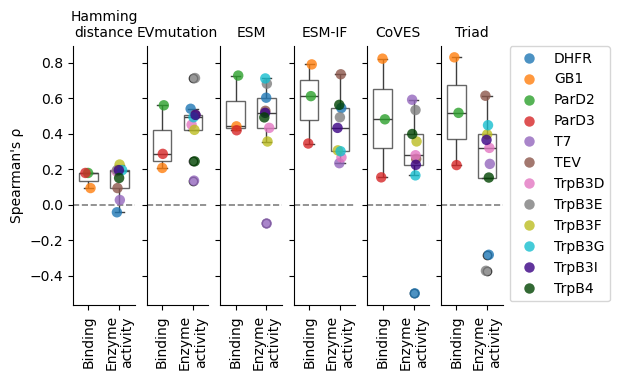

ed_score t=-3.352 and p=0.010
ev_score t=-0.111 and p=0.927
esm_score t=0.523 and p=0.667
esmif_score t=4.078 and p=0.008
coves_score t=3.126 and p=0.043
Triad_score t=5.017 and p=0.001


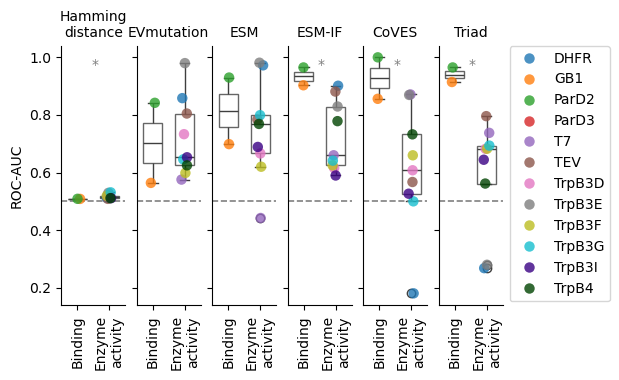

In [15]:
# for single mutation > 1% active
for m in ["rho", "rocauc"]:
    plot_app_type_zs(
        metric=m,
        n_mut="single",
        slice_zs=zs_df[zs_df["lib"].isin(active_lib_list)].copy(),
        y_annotation = 0.95,
        fig_name = "s19",
        # save_dir = "fig",
        # if_save = True,
    )

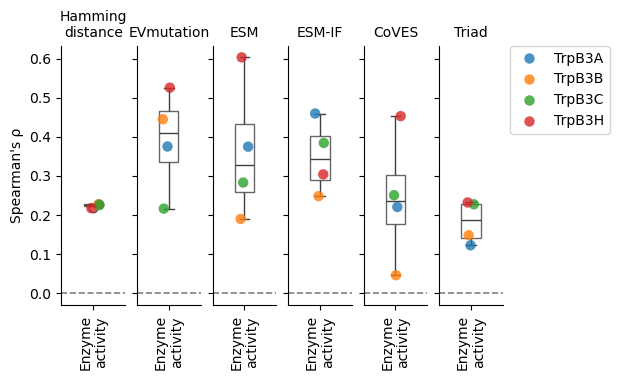

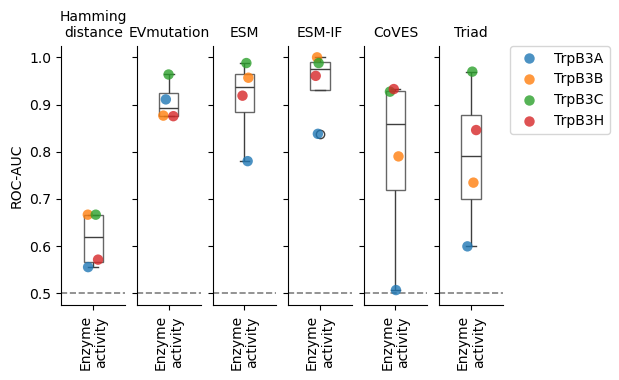

In [16]:
# for single mutation <1% active 
for m in ["rho", "rocauc"]:
    plot_app_type_zs(
        metric=m,
        n_mut="single",
        slice_zs=zs_df[~zs_df["lib"].isin(active_lib_list)].copy(),
        fig_name = "s20",
        # save_dir = "fig",
        # if_save = True,
    )